<a href="https://colab.research.google.com/github/eunseo-hoot/eunseo-hoot.github.io/blob/main/Parkinson's_Disease_Detection_with_Ensemble_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
debasisdotcom_parkinson_disease_detection_path = kagglehub.dataset_download('debasisdotcom/parkinson-disease-detection')

print('Data source import complete.')


Data source import complete.


# Parkinson's Disease Detection using Voice Features with Machine Learning Models and Ensemble Voting Classifier
![Parkinson.png](attachment:c9bc1418-4dfc-4c98-8d30-21106601aa27.png)
## Introduction
This notebook explores the use of voice features to predict Parkinson's disease (PD). The dataset includes various voice metrics that are used to detect the presence of PD in individuals. The features are based on the fundamental frequency, jitter, shimmer, noise-to-harmonic ratio, harmonic-to-noise ratio, and nonlinear dynamics, which collectively help in understanding the voice characteristics of individuals with Parkinson's disease.

## Breakdown of Key Columns

### **Basic Frequency Metrics:**
- **MDVP:Fo(Hz):** The fundamental frequency, representing the average pitch of the voice.
- **MDVP:Fhi(Hz):** The maximum fundamental frequency, which indicates the highest pitch in the voice signal.
- **MDVP:Flo(Hz):** The minimum fundamental frequency, representing the lowest pitch in the voice signal.

### **Jitter (Frequency Variation):**
- **MDVP:Jitter(%):** Represents the percentage of frequency variation (jitter) in the voice, indicating irregularities in the pitch.
- **MDVP:Jitter(Abs):** Absolute jitter, measuring the raw amount of frequency perturbation.
- **MDVP:RAP, MDVP:PPQ, Jitter:DDP:** Additional specific jitter metrics that help quantify variations in frequency over time, offering different ways to calculate pitch irregularities.

### **Shimmer (Amplitude Variation):**
- **MDVP:Shimmer:** Measures amplitude variation, indicating the fluctuation in the loudness of the voice signal.
- **MDVP:Shimmer(dB):** A decibel-based version of shimmer that quantifies amplitude perturbations in logarithmic units.
- **Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA:** Various shimmer metrics that assess different aspects of amplitude instability, including short-term and long-term variations.

### **Noise-to-Harmonic Ratio (NHR):**
- **NHR:** Quantifies the amount of noise relative to the harmonic components of the voice, providing insights into the vocal quality. A higher NHR suggests a noisier voice signal.

### **Harmonic-to-Noise Ratio (HNR):**
- **HNR:** Measures the ratio of harmonics (clear voice signal) to noise. A higher value indicates better voice signal clarity and less noise.

### **Nonlinear Dynamics:**
- **RPDE:** Recurrence period density entropy, a measure of the complexity and periodicity in the voice signal.
- **DFA:** Detrended fluctuation analysis, a method used to analyze the self-similarity of the voice signal, revealing long-term dependencies and fractal-like behavior.

### **Signal Spread and Complexity:**
- **spread1, spread2:** Measures of variations in signal spread, helping to understand how the signal fluctuates over time.
- **D2:** Correlation dimension, a metric for measuring the complexity and the number of dimensions in the signal. It helps quantify the dynamic complexity of the voice signal.

### **PPE (Pitch Period Entropy):**
- **PPE:** Pitch period entropy quantifies the irregularity or disorder in the pitch periods, indicating the level of unpredictability in the voice signal.

### **Target Variable:**
- **status:** This is the target variable, where 1 represents that the individual has Parkinson's disease (affected) and 0 represents a healthy individual.


## Import Necessary Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi
from sklearn.model_selection import train_test_split, learning_curve
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

## Load the Dataset


In [6]:
data = pd.read_csv('/kaggle/input/parkinson-disease-detection/Parkinsson disease.csv')
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [7]:
# Shape of the data
data.shape

(195, 24)

## Exploratory Data Analysis (EDA)
### Basic Information

In [8]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [9]:
# Rename columns to remove special characters
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

In [10]:
# Describe the dataset
data.describe()

,MDVPFoHz,MDVPFhiHz,MDVPFloHz,MDVPJitter,MDVPJitterAbs,MDVPRAP,MDVPPPQ,JitterDDP,MDVPShimmer,MDVPShimmerdB,...,ShimmerDDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


### Check for Missing Values

In [11]:
# Check for missing values in the dataset
data.isnull().sum().sum()

np.int64(0)

### Check for Duplicate Values

In [12]:
# Check for duplicate rows in the dataset
data.duplicated().sum()

np.int64(0)

### Target Variable Distribution

In [13]:
# Value distribution of the target variable
data['status'].value_counts()

,count
status,
1,147
0,48


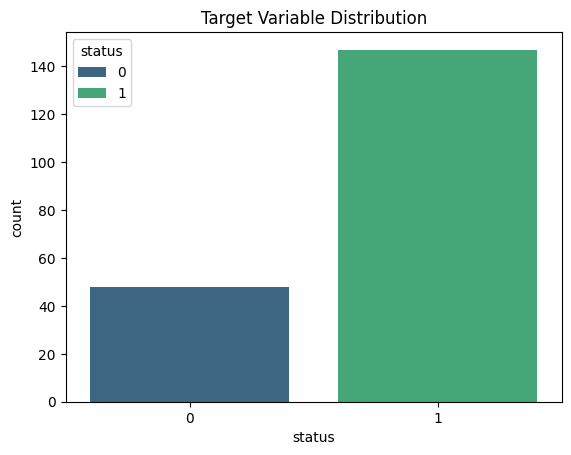

In [14]:
# Visualize the distribution of the target variable
sns.countplot(x='status', data=data, palette='viridis', hue='status')
plt.title('Target Variable Distribution')
plt.show()

## Feature Selection

### Remove Unnecessary Columns

In [15]:
# Remove name column
data.drop('name', axis=1, inplace=True)

### Separate Features and Target

In [16]:
# Separate features and target
X = data.drop(columns=['status'])  # Exclude target column
y = data['status']

### Remove Highly Correlated Features

In [17]:
# Calculate correlation matrix
correlation_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find features with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
X = X.drop(columns=to_drop)
print(f"Dropped columns: {to_drop}")

Dropped columns: ['MDVPJitterAbs', 'MDVPRAP', 'MDVPPPQ', 'JitterDDP', 'MDVPShimmerdB', 'ShimmerAPQ3', 'ShimmerAPQ5', 'MDVPAPQ', 'ShimmerDDA', 'NHR', 'PPE']


### Feature Correlation

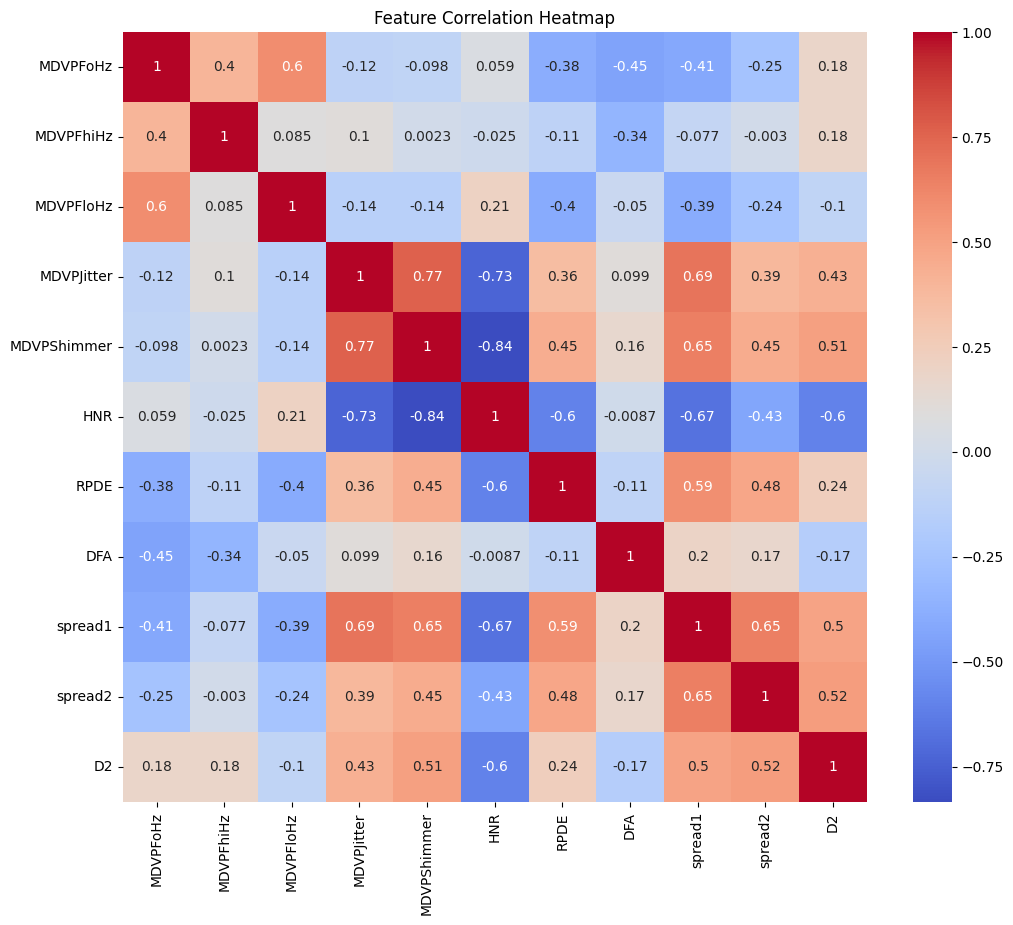

In [18]:
# Visualize feature correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap='coolwarm', annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

## Train-Test Split

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling the Data

In [20]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training and Evaluation
### Define Function for Model Training

In [21]:
# Define a function to train and evaluate multiple models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    metrics = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        metrics.append({
            'Model': name,
            'Accuracy': accuracy,
            'AUC-ROC': auc_roc,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
        print(f"{name} - Accuracy: {accuracy:.4f}, AUC-ROC: {auc_roc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return pd.DataFrame(metrics)

models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
}

# Train and evaluate models
metrics_df = train_and_evaluate(models, X_train, X_test, y_train, y_test)

XGBoost - Accuracy: 0.9487, AUC-ROC: 0.8571, Precision: 0.9412, Recall: 1.0000, F1-Score: 0.9697
SVM (RBF Kernel) - Accuracy: 0.9231, AUC-ROC: 0.7857, Precision: 0.9143, Recall: 1.0000, F1-Score: 0.9552
LogisticRegression - Accuracy: 0.8974, AUC-ROC: 0.7143, Precision: 0.8889, Recall: 1.0000, F1-Score: 0.9412


In [22]:
metrics_df

,Model,Accuracy,AUC-ROC,Precision,Recall,F1-Score
0,XGBoost,0.948718,0.857143,0.941176,1.0,0.969697
1,SVM (RBF Kernel),0.923077,0.785714,0.914286,1.0,0.955224
2,LogisticRegression,0.897436,0.714286,0.888889,1.0,0.941176


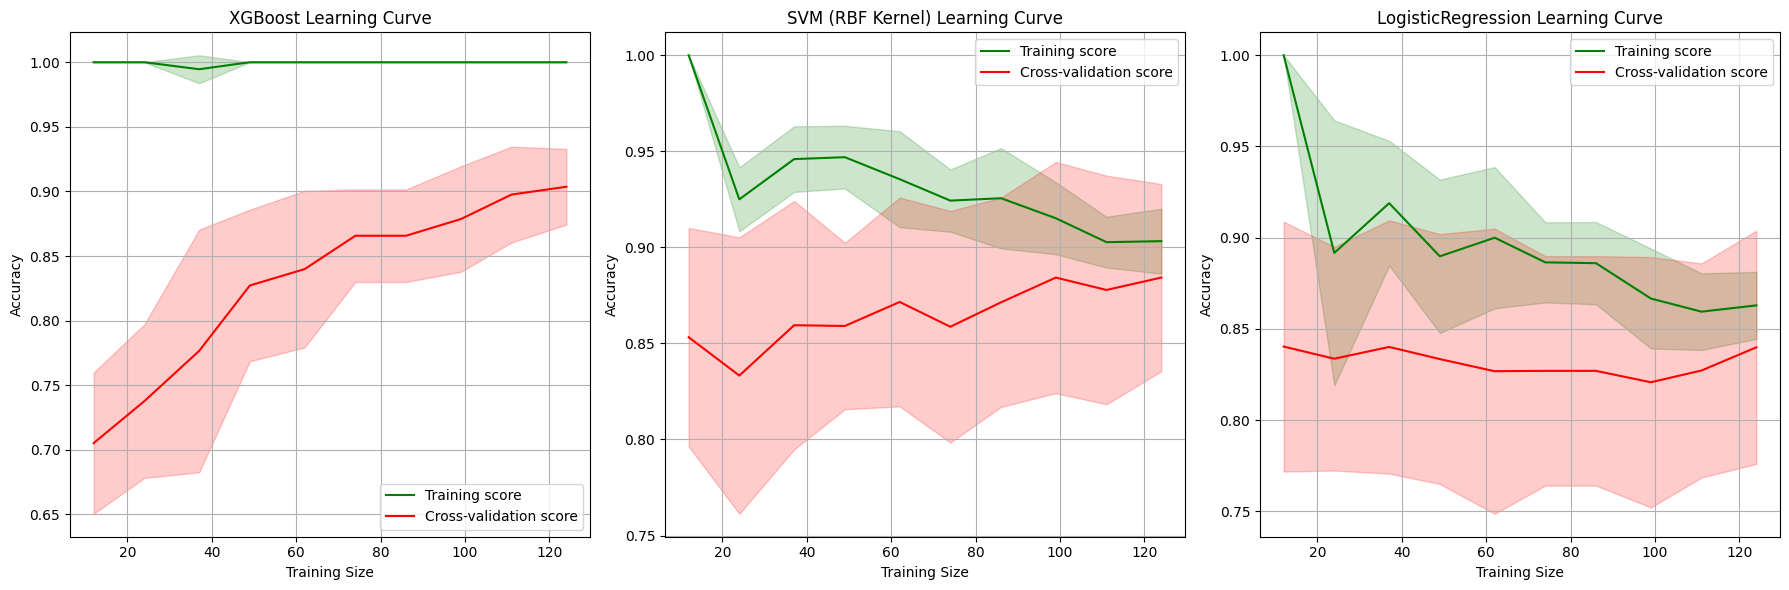

In [23]:
# Function to plot learning curve
def plot_learning_curve(model, X_train, y_train, ax, title="Learning Curve", cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

    # Calculate mean and std deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plotting on the given axis
    ax.plot(train_sizes, train_mean, label="Training score", color="green")
    ax.plot(train_sizes, test_mean, label="Cross-validation score", color="red")
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="green")
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")

    ax.set_title(title)
    ax.set_xlabel("Training Size")
    ax.set_ylabel("Accuracy")
    ax.legend(loc="best")
    ax.grid()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, model) in enumerate(models.items()):
    plot_learning_curve(model, X_train, y_train, axes[i], title=f"{name} Learning Curve")

plt.tight_layout()
plt.show()


## Ensemble Voting (Majority Voting)

In [24]:
# Combine models using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('svm', models['SVM (RBF Kernel)']),
        ('lr', models['LogisticRegression'])
    ], voting='hard'
)

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_auc_roc = roc_auc_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)

new_metrics = pd.DataFrame([{
    'Model': 'Majority Voting (Ensemble)',
    'Accuracy': ensemble_accuracy,
    'AUC-ROC': ensemble_auc_roc,
    'Precision': ensemble_precision,
    'Recall': ensemble_recall,
    'F1-Score': ensemble_f1
}])

metrics_df = pd.concat([metrics_df, new_metrics], ignore_index=True)

print(f"Ensemble - Accuracy: {ensemble_accuracy:.4f}, AUC-ROC: {ensemble_auc_roc:.4f}, Precision: {ensemble_precision:.4f}, Recall: {ensemble_recall:.4f}, F1-Score: {ensemble_f1:.4f}")

Ensemble - Accuracy: 0.9231, AUC-ROC: 0.7857, Precision: 0.9143, Recall: 1.0000, F1-Score: 0.9552


In [ ]:
metrics_df

## Results Comparison


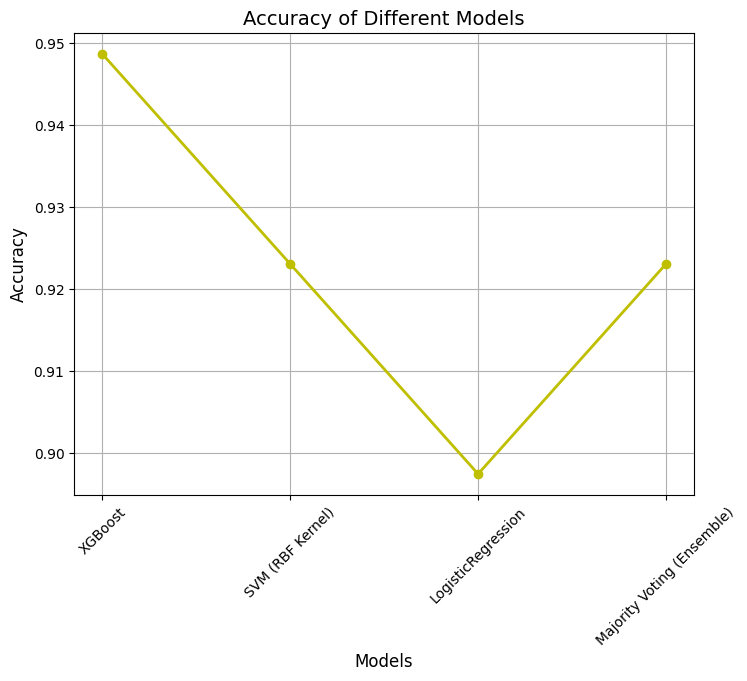

In [25]:
# Plot the Accuracy column using a line plot
plt.figure(figsize=(8, 6))
plt.plot(metrics_df['Model'], metrics_df['Accuracy'], marker='o', color='y', linestyle='-', linewidth=2)

# Adding titles and labels
plt.title('Accuracy of Different Models', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.show()


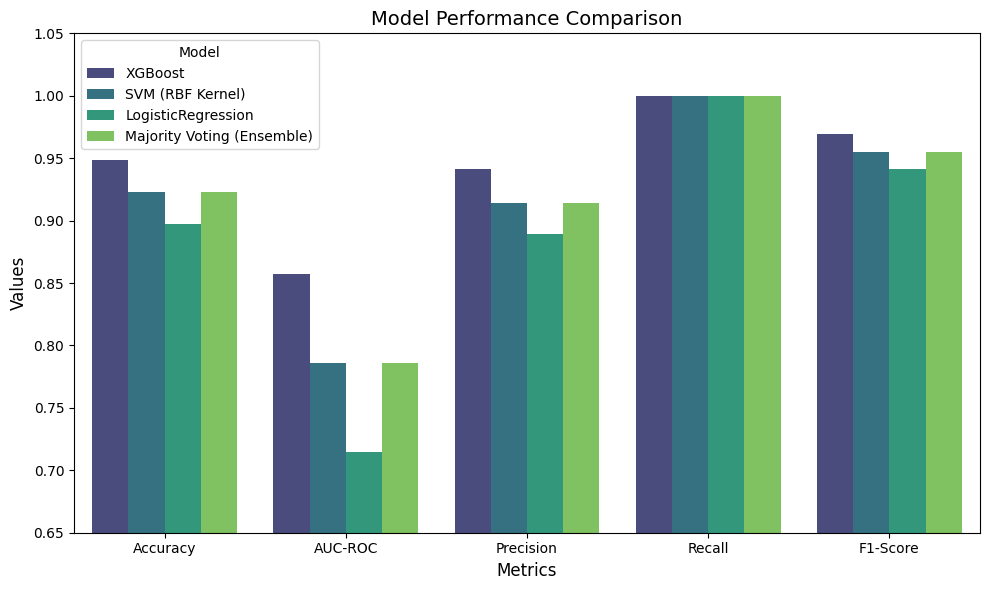

In [26]:
# Metrics to plot
metrics_to_plot = ['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']

# Melt the metrics dataframe
melted_df = metrics_df.melt(
    id_vars=["Model"], value_vars=metrics_to_plot,
    var_name="Metric", value_name="Value"
)

# Plot for all models
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Metric",
    y="Value",
    hue="Model",
    data=melted_df,
    palette="viridis",
    dodge=True
)
plt.title("Model Performance Comparison", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Model", fontsize=10)
plt.ylim(0.65, None)
plt.tight_layout()

plt.show()


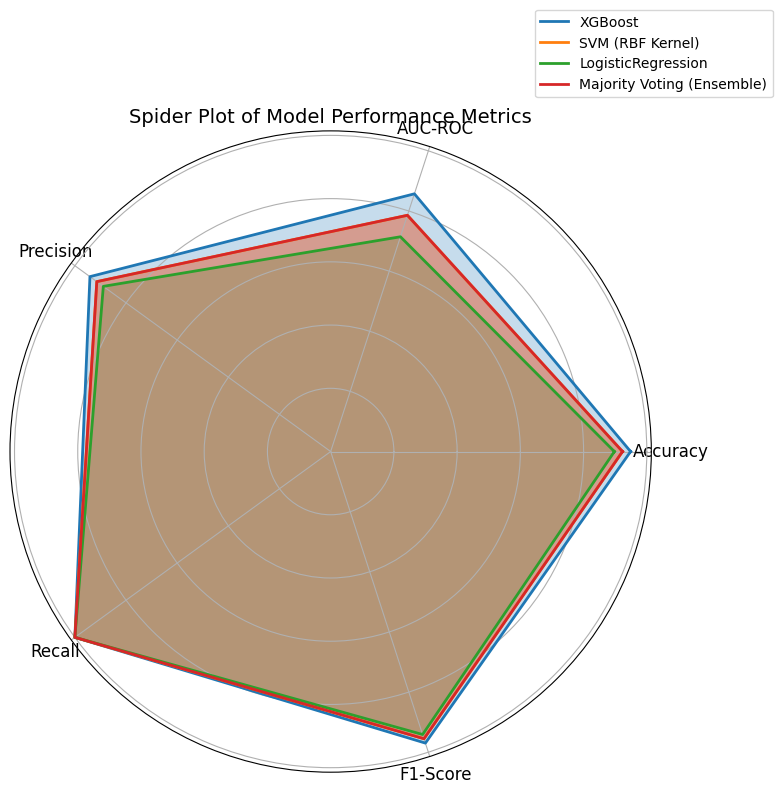

In [27]:
# Function to plot radar chart for all models together
def plot_spider_chart(df):
    labels = ['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Create the plot for all models
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Loop through all models and plot their performance
    for model_name in df['Model'].unique():
        model_metrics = df[df['Model'] == model_name].iloc[0, 1:].values
        model_metrics = np.concatenate((model_metrics, [model_metrics[0]]))
        ax.plot(angles, model_metrics, linewidth=2, linestyle='solid', label=model_name)
        ax.fill(angles, model_metrics, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_title("Spider Plot of Model Performance Metrics", size=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
    plt.tight_layout()
    plt.show()

plot_spider_chart(metrics_df)


### Conclusion

- **XGBoost** outperformed all models with the highest accuracy (94.87%) and F1-Score (96.97%).
- **SVM (RBF Kernel)** and **Majority Voting (Ensemble)** both showed strong performance, with accuracy (92.31%) and F1-Score (95.52%) slightly lower than XGBoost.
- **Logistic Regression** had the lowest performance with accuracy (89.74%) and F1-Score (94.12%).
- All models had perfect recall (1.0), showing no issues with detecting positive instances.
  
**XGBoost** is the top performer, but **SVM** and **Majority Voting** are also reliable alternatives.